In [72]:
import pandas as pd

## Cost to DAG run duration

In [73]:
data = pd.read_csv('./prom_data.csv')
machine_type = data['machine_type'].values[0]
data.head()

,executor_instances,executor_memory,driver_memory,status,machine_type,dag_id,dag_duration
0,2,512,512,success,e2-standard-4,ngs-pipeline,1186
1,4,512,512,success,e2-standard-4,ngs-pipeline,1210
2,2,550,600,success,e2-standard-4,ngs-pipeline,1070
3,4,550,600,success,e2-standard-4,ngs-pipeline,1060
4,2,600,750,success,e2-standard-4,ngs-pipeline,1000


In [74]:
# e2-standard-4 (europe-west1) https://cloud.google.com/compute/vm-instance-pricing
machine_cost_per_hour = 0.147428

def cost_function(machine_cost_per_hour, r):
    return (machine_cost_per_hour / 60) * (r['executor_instances'] + 1) * (r['dag_duration'] / 60)

for index, row in data.iterrows():
    print(cost_function(machine_cost_per_hour, row))

data['cost'] = (machine_cost_per_hour / 60) * (data['executor_instances'] + 1) * (data['dag_duration'] / 60)
data.head()

0.14570800666666667
0.24776094444444446
0.13145663333333332
0.2170467777777778
0.12285666666666668
0.22933244444444445
0.10565673333333334
0.20148493333333334
0.11683669
0.17199933333333334
0.0884568
0.0847711
0.12777093333333334
0.12285666666666668
0.06552355555555556
0.0663426
0.1920659222222222
0.19493257777777778
0.42795072222222225
0.4144364888888889
0.16462793333333334
0.34891293333333334
0.07862826666666667
0.0810854


,executor_instances,executor_memory,driver_memory,status,machine_type,dag_id,dag_duration,cost
0,2,512,512,success,e2-standard-4,ngs-pipeline,1186,0.145708
1,4,512,512,success,e2-standard-4,ngs-pipeline,1210,0.247761
2,2,550,600,success,e2-standard-4,ngs-pipeline,1070,0.131457
3,4,550,600,success,e2-standard-4,ngs-pipeline,1060,0.217047
4,2,600,750,success,e2-standard-4,ngs-pipeline,1000,0.122857


<AxesSubplot:xlabel='cost', ylabel='dag_duration'>

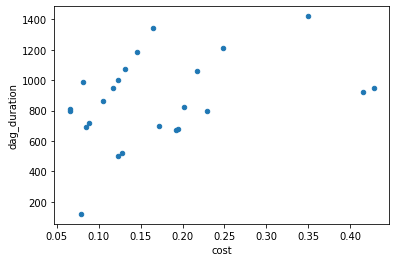

In [75]:
data.plot.scatter(y='dag_duration', x='cost')


<AxesSubplot:xlabel='dag_duration', ylabel='cost'>

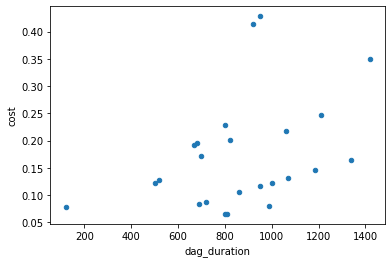

In [76]:
data.plot.scatter(x='dag_duration', y='cost')


In [77]:
import plotly.express as px

fig = px.scatter(data, x="dag_duration", y="cost", color="status", title=machine_type, hover_data=['executor_instances', 'executor_memory', 'driver_memory', 'machine_type', 'dag_id'])

fig.show()